# **Ejercicio 3.1**

Supongamos que tenemos un dataset mezcla de dos grupos aleatorios bidimensionales (cada uno con 100 datos, su centroide y covariancia).

Encontrar un clasificador por K-NN y evaluar exactitud, precisión, f-measure. Tomar inicialmente un dataset de entrenamiento de N=100 (50+50), k=10 y validar con el resto del dataset. Hacer algunos experimentos con otros N y k, y también cambiando centroide y covariancia de las clases.

¿Cambia mucho si el dataset tiene más dimensiones?

## **Importar Librerías**

In [ ]:
# Usaremos las siguientes bibliotecas
# Datos
import numpy as np 
import pandas as pd 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## **Generar dataset**
Procedo a crear el dataset donde los atributos tengan distribuciones normales.

In [ ]:
# Genero primero el dataset que represente el atributo X para cada clase A y B con centoroides y DS distintas
np.random.seed(1)
meanX_A = 0
meanX_B = 0.5
dsX_A = 0.2
dsX_B = 0.3
dfX = pd.DataFrame(np.random.normal(loc=[meanX_A,meanX_B], scale=[dsX_A,dsX_B], size=(100, 2)),columns=['X_A','X_B'])

# Ahora genero el dataset que represente el atributo Y para cada clase A y B con centoroides y DS distintas
np.random.seed(2)
meanY_A = 4
meanY_B = 8
dsY_A = 2
dsY_B = 3
dfY = pd.DataFrame(np.random.normal(loc=[meanY_A,meanY_B], scale=[dsY_A,dsY_B], size=(100, 2)),columns=['Y_A','Y_B'])

# Ahora a la clase A la voy a identificar con un 0 y a la clase B con un 1.
# Por último genero el dataset que me junte los atributos X e Y de cada clase y me muestre la etiqueta en la primer columna

dfA = pd.DataFrame({"etiqueta":np.zeros((100,), dtype=int), "X":dfX['X_A'], "Y":dfY['Y_A']})
dfB = pd.DataFrame({"etiqueta":np.ones((100,), dtype=int), "X":dfX['X_B'], "Y":dfY['Y_B']})

data = pd.concat([dfA,dfB], ignore_index=True)
data 


,etiqueta,X,Y
0,0,0.324869,3.166484
1,0,-0.105634,-0.272392
2,0,0.173082,0.413129
3,0,0.348962,5.005763
4,0,0.063808,1.884096
...,...,...,...
195,1,0.610848,10.275111
196,1,0.833317,5.877737
197,1,0.011768,13.413430
198,1,0.626085,9.659493


## **Diagrama de dispersión**
Ahora relicemos un diagrama de dispersión para observar cómo se acumulan los datos.

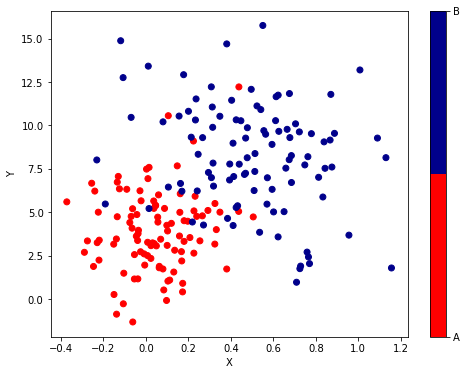

In [ ]:
# Esto lo necesito para identificar los colores en el scatter plot con sus respectivas etiquetas
etiquetas = ['A','B']
formatter = plt.FuncFormatter(lambda i, *args: etiquetas[int(i)])

plt.figure(figsize=(8, 6))
cmap_scatter = ListedColormap(['red', 'darkblue'])
plt.scatter(data["X"], data["Y"], c=data["etiqueta"], cmap=cmap_scatter)
plt.colorbar(ticks=[0, 1], format=formatter)
plt.xlabel("X")
plt.ylabel("Y")

plt.show()

## **Clasificador por K vecinos más cercanos**
Vemos que existe una región donde los datos se "mezclan". Procedamos a entrenar el clasificador de k vecinos más cercanos.

In [ ]:
# Genero los datasets de entrenamiento y de validación
N_train = 100

data_train_A = data.iloc[0:N_train//2,:]
data_train_B = data.iloc[N_train:N_train+N_train//2,:]
data_train = pd.concat([data_train_A,data_train_B], ignore_index=True)

X_train = data_train.iloc[:,1:3].values
y_train = data_train.iloc[:,0].values

data_valid_A = data.iloc[N_train//2:N_train,:]
data_valid_B = data.iloc[N_train+N_train//2:2*N_train,:]
data_valid = pd.concat([data_valid_A,data_valid_B], ignore_index=True)

X_valid = data_valid.iloc[:,1:3].values
y_valid = data_valid.iloc[:,0].values

# Entreno el clasificador
from sklearn import neighbors

k_vecinos = 10  # Número de vecino a considerar

knn = neighbors.KNeighborsClassifier(n_neighbors=k_vecinos)
knn.fit(X_train,y_train)

# Calculo las predicciones con los datos que guardé para validar
y_pred = knn.predict(X_valid)

## **Dominios de decisión del clasificador**
Grafiquemos ahora los dominios de decisión del clasificador.

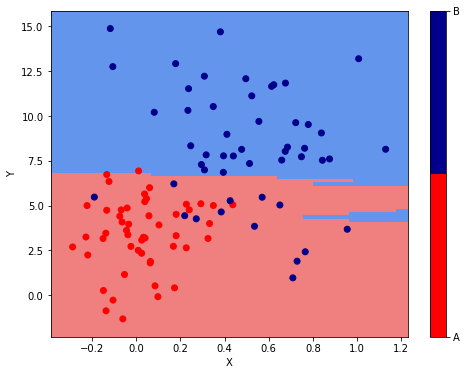

In [ ]:
def figura_dominios(X_train, y_train, knn):

  # Create color maps for 2-class classification problem
  cmap_light = ListedColormap(['lightcoral', 'cornflowerblue'])
  cmap_bold = ListedColormap(['red', 'darkblue'])

  x_min, x_max = X_train[:, 0].min() - .1, X_train[:, 0].max() + .1
  y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),np.linspace(y_min, y_max, 100))

  Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  plt.figure(figsize=(8, 6))
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

  # Plot also the training points
  plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold)
  plt.colorbar(ticks=[0, 1], format=formatter)
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.axis('tight')

figura_dominios(X_train, y_train, knn)

Observamos en rojo y azul los dominios dónde el clasificador predecirá si un nuevo dato pertenece a la clase A o B, respectivamente. Hay una región que me llama la atención abajo a la derecha donde el dominio es rojo pero se ven muchos puntos azules de la clase B y ninguno de la clase A. Para ver si es tema del clasificador o del gráfico voy a predecir la clase para un valor de (X, Y) = (6.0, 1.0)

In [ ]:
print(knn.predict([[6.0, 1.0]]))

[0]


AL igual que en la figura el clasificador me predice que el punto va a ser de la clase A. Pero en el gráfico veo que los 7 puntos más cercanos son de la clase B. Sin embargo, observo que los ejes no están en la misma escala, las distancias en el eje x en el gráfico son mucho más cercanas. Por lo que tiene sentido que me prediga la clase A.

## **Parámetros de evaluación**
Validemos ahora el clasificador con el resto del dataset, evaluando con el resto de los datos (data_valid) la exactitud, precisión y f-measure del mismo.

In [ ]:
# Defino una función que calcule los parámetros así la puedo volver a usar más adelante cambiando los valores de k y N
# Considero a la clase B o 1 como la positiva

def parametros(prediction,condition):

  TP = 0  #True Positive
  FP = 0  #False Positive
  TN = 0  #True Negative
  FN = 0  #False Negative

  i = 0
  for cond in condition:
    pred = prediction[i]
    i += 1  
    if cond == 1: #Positive
      if pred == cond:  #True Positive
        TP += 1
      else: #False Negative
        FN += 1
    elif cond == 0: #Negative
      if pred == cond:  #True Negative
        TN += 1
      else: #False Positive
        FP += 1

  condP = TP + FN #Condition Positive
  condN = FP + TN #Condition Negative
  predP = TP + FP #Prediction Positive
  predN = FN + TN #Prediction Negative

  #TPR
  TPR = TP / condP
  #FPR
  FPR = FP / condN
  #Exactitud
  accuracy = (TP + TN) / (condN + condP)
  #Precision
  precision = TP / predP
  #f-measure
  f_measure = (2 * precision * TPR) / (precision + TPR)

  return accuracy, precision, f_measure

In [ ]:
accuracy_N100_k10, precision_N100_k10, f_measure_N100_k10 = parametros(y_pred, y_valid)

from tabulate import tabulate

tabla = [['KNN Classifier', 'N = {} and k = {}'.format(N_train,k_vecinos)],
         ['Exactitud', round(accuracy_N100_k10,2)],
         ['Precisión', round(precision_N100_k10,2)],
         ['f-measure', round(f_measure_N100_k10,2)]]
        
print(tabulate(tabla,
               tablefmt='fancy_grid',
               stralign='center'))

╒════════════════╤════════════════════╕
│ KNN Classifier │ N = 100 and k = 10 │
├────────────────┼────────────────────┤
│   Exactitud    │        0.78        │
├────────────────┼────────────────────┤
│   Precisión    │        0.83        │
├────────────────┼────────────────────┤
│   f-measure    │        0.76        │
╘════════════════╧════════════════════╛


Al observar los parámetros de evaluación vemos que presentan valor relativamente aceptables. Veamos si se pueden mejorar con otros valores de N y k. 
## **Modificando el valor de k**
Probemos inicialmente para valores de k entre 1 y N/2.

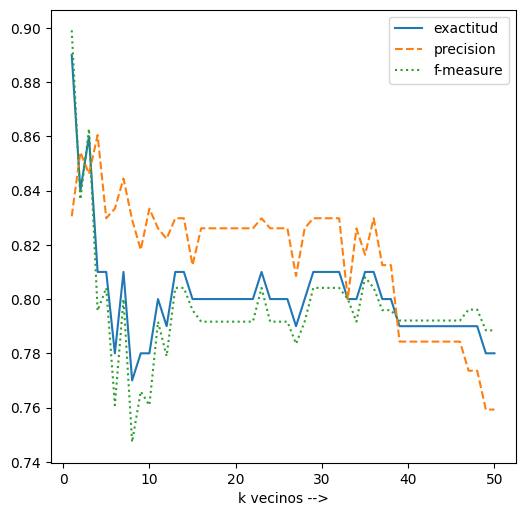

In [ ]:
k_vecinos_max = N_train//2

accuracy = np.ones([k_vecinos_max], dtype=np.float64)
precision = np.ones([k_vecinos_max], dtype=np.float64)
f_measure = np.ones([k_vecinos_max], dtype=np.float64)
x = np.ones([k_vecinos_max], dtype=np.float64)

for k_vecinos in range(1,k_vecinos_max+1):
  x[k_vecinos-1] = k_vecinos
  knn = neighbors.KNeighborsClassifier(n_neighbors=k_vecinos)
  knn.fit(X_train,y_train)
  y_pred = knn.predict(X_valid)
  accuracy[k_vecinos-1], precision[k_vecinos-1], f_measure[k_vecinos-1] = parametros(y_pred, y_valid)

plt.figure(figsize=(6, 6), dpi=100)
plt.plot(x, accuracy, linestyle='solid', label='exactitud')
plt.plot(x, precision, linestyle='dashed', label='precision')
plt.plot(x, f_measure, linestyle='dotted', label='f-measure')

plt.xlabel('k vecinos -->')

plt.legend()

plt.show()

A partir de las curvas en función del número de vecinos, vemos que existe una región donde el modelo es bastante estable en lo que respecta a los valores de exactitud y precisión. Esto ocurre aproximadamente para valores de k entre 10 y 35. Por debajo de estos valores, tanto la exactitud como la precisión arrojan valores más altos pero uno tendría miedo de que el modelo sea bastante inestable como para considerar valores bajos de k. Lo que puede estar ocurriendo es que las categorías están bien agrupadas (con centroides lejanos y covariancias pequeñas) por lo que pequeños valores de k presentan buen comporamiento. Por encima de k = 35 observamos que los parámetros de evaluación decaen. Grafiquemos dos casos distintos de k bajo y alto para observar los dominios de decisión.

(None, None)

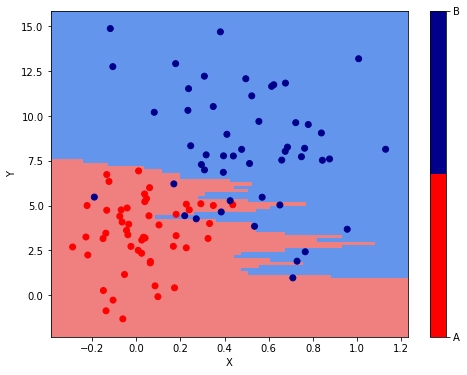

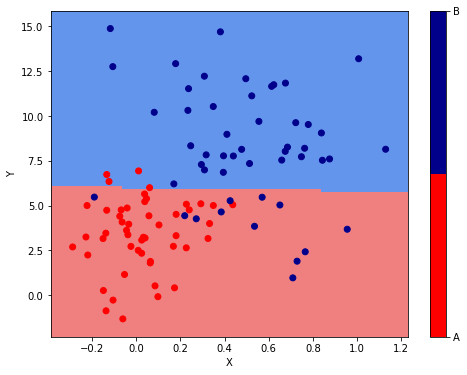

In [ ]:
# k =  3
knn3 = neighbors.KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train,y_train)
# k =  50
knn50 = neighbors.KNeighborsClassifier(n_neighbors=50)
knn50.fit(X_train,y_train)

figura_dominios(X_train, y_train, knn3) , figura_dominios(X_train, y_train, knn50)

En el primer gráfico (k = 3) vemos que hay regiones muy inestables donde una pequeña variación en alguno de los atributos X o Y cambia la predicción entre A y B, por lo que podríamos tener problemas de overfitting. En cambio, en el segundo caso (k = 50), observamos que el borde entre las dos regiones está muy bien definido y podríamos tener problemas de underfitting si las clases no fueran simétricas, es decir, que se priorice la clase mayoritaria.

## **Modificando el valor de N**
Evaluemos cómo cambia nuestro modelo si reducimos el valor de datos que usaremos para entrenar al clasificador, considerando siempre un valor de k de aproximadamente la raíz de N.

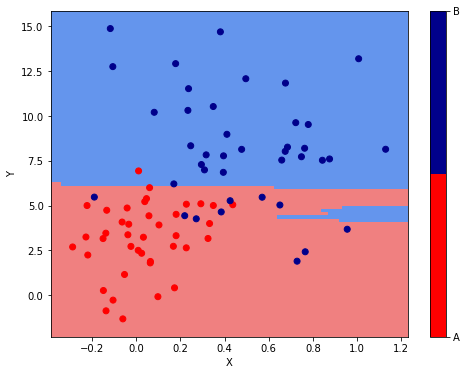

In [ ]:
# Genero los datasets de entrenamiento y de validación
N_train = 80

data_train_A = data.iloc[0:N_train//2,:]
data_train_B = data.iloc[100:100+N_train//2,:]
data_train = pd.concat([data_train_A,data_train_B], ignore_index=True)

X_train = data_train.iloc[:,1:3].values
y_train = data_train.iloc[:,0].values

data_valid_A = data.iloc[N_train//2:100,:]
data_valid_B = data.iloc[100+N_train//2:200,:]
data_valid = pd.concat([data_valid_A,data_valid_B], ignore_index=True)

X_valid = data_valid.iloc[:,1:3].values
y_valid = data_valid.iloc[:,0].values

# Entreno el clasificador
k_vecinos = 9  # Número de vecino a considerar

knn = neighbors.KNeighborsClassifier(n_neighbors=k_vecinos)
knn.fit(X_train,y_train)

# Calculo las predicciones con los datos que guardé para validar
y_pred = knn.predict(X_valid)

figura_dominios(X_train, y_train, knn)

accuracy_N80_k9, precision_N80_k9, f_measure_N80_k9 = parametros(y_pred, y_valid)

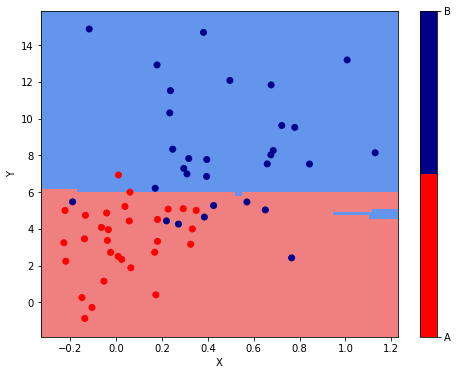

In [ ]:
# Genero los datasets de entrenamiento y de validación
N_train = 60

data_train_A = data.iloc[0:N_train//2,:]
data_train_B = data.iloc[100:100+N_train//2,:]
data_train = pd.concat([data_train_A,data_train_B], ignore_index=True)

X_train = data_train.iloc[:,1:3].values
y_train = data_train.iloc[:,0].values

data_valid_A = data.iloc[N_train//2:100,:]
data_valid_B = data.iloc[100+N_train//2:200,:]
data_valid = pd.concat([data_valid_A,data_valid_B], ignore_index=True)

X_valid = data_valid.iloc[:,1:3].values
y_valid = data_valid.iloc[:,0].values

# Entreno el clasificador
k_vecinos = 8  # Número de vecino a considerar

knn = neighbors.KNeighborsClassifier(n_neighbors=k_vecinos)
knn.fit(X_train,y_train)

# Calculo las predicciones con los datos que guardé para validar
y_pred = knn.predict(X_valid)

figura_dominios(X_train, y_train, knn)

accuracy_N60_k8, precision_N60_k8, f_measure_N60_k8 = parametros(y_pred, y_valid)

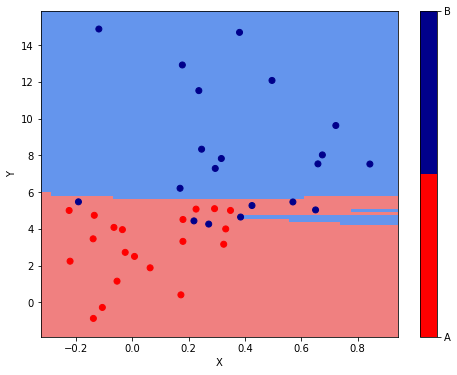

In [ ]:
# Genero los datasets de entrenamiento y de validación
N_train = 40

data_train_A = data.iloc[0:N_train//2,:]
data_train_B = data.iloc[100:100+N_train//2,:]
data_train = pd.concat([data_train_A,data_train_B], ignore_index=True)

X_train = data_train.iloc[:,1:3].values
y_train = data_train.iloc[:,0].values

data_valid_A = data.iloc[N_train//2:100,:]
data_valid_B = data.iloc[100+N_train//2:200,:]
data_valid = pd.concat([data_valid_A,data_valid_B], ignore_index=True)

X_valid = data_valid.iloc[:,1:3].values
y_valid = data_valid.iloc[:,0].values

# Entreno el clasificador
k_vecinos = 6  # Número de vecino a considerar

knn = neighbors.KNeighborsClassifier(n_neighbors=k_vecinos)
knn.fit(X_train,y_train)

# Calculo las predicciones con los datos que guardé para validar
y_pred = knn.predict(X_valid)

figura_dominios(X_train, y_train, knn)

accuracy_N40_k6, precision_N40_k6, f_measure_N40_k6 = parametros(y_pred, y_valid)

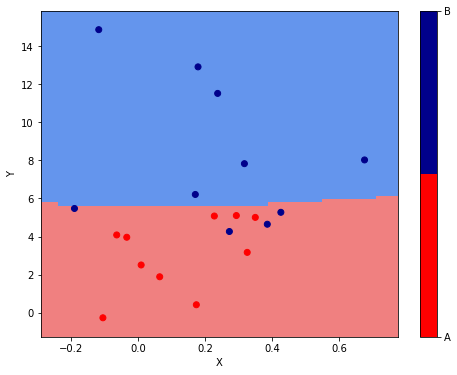

In [ ]:
# Genero los datasets de entrenamiento y de validación
N_train = 20

data_train_A = data.iloc[0:N_train//2,:]
data_train_B = data.iloc[100:100+N_train//2,:]
data_train = pd.concat([data_train_A,data_train_B], ignore_index=True)

X_train = data_train.iloc[:,1:3].values
y_train = data_train.iloc[:,0].values

data_valid_A = data.iloc[N_train//2:100,:]
data_valid_B = data.iloc[100+N_train//2:200,:]
data_valid = pd.concat([data_valid_A,data_valid_B], ignore_index=True)

X_valid = data_valid.iloc[:,1:3].values
y_valid = data_valid.iloc[:,0].values

# Entreno el clasificador
k_vecinos = 4  # Número de vecino a considerar

knn = neighbors.KNeighborsClassifier(n_neighbors=k_vecinos)
knn.fit(X_train,y_train)

# Calculo las predicciones con los datos que guardé para validar
y_pred = knn.predict(X_valid)

figura_dominios(X_train, y_train, knn)

accuracy_N20_k4, precision_N20_k4, f_measure_N20_k4 = parametros(y_pred, y_valid)

In [ ]:
tabla = [['KNN Classifier', 'N = 100 and k = 10', 'N = 80 and k = 9', 'N = 60 and k = 8', 'N = 40 and k = 6', 'N = 20 and k = 4'],
         ['Exactitud', round(accuracy_N100_k10,2), round(accuracy_N80_k9,2), round(accuracy_N60_k8,2), round(accuracy_N40_k6,2), round(accuracy_N20_k4,2)],
         ['Precisión', round(precision_N100_k10,2), round(precision_N80_k9,2), round(precision_N60_k8,2), round(precision_N40_k6,2), round(precision_N20_k4,2)],
         ['f-measure', round(f_measure_N100_k10,2), round(f_measure_N80_k9,2), round(f_measure_N60_k8,2), round(f_measure_N40_k6,2), round(f_measure_N20_k4,2)]]
        
print(tabulate(tabla,
               tablefmt='fancy_grid',
               stralign='center'))

╒════════════════╤════════════════════╤══════════════════╤══════════════════╤══════════════════╤══════════════════╕
│ KNN Classifier │ N = 100 and k = 10 │ N = 80 and k = 9 │ N = 60 and k = 8 │ N = 40 and k = 6 │ N = 20 and k = 4 │
├────────────────┼────────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│   Exactitud    │        0.78        │       0.78       │       0.8        │       0.79       │       0.79       │
├────────────────┼────────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│   Precisión    │        0.83        │       0.77       │       0.8        │       0.78       │       0.79       │
├────────────────┼────────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│   f-measure    │        0.76        │       0.79       │       0.8        │       0.8        │       0.8        │
╘════════════════╧════════════════════╧══════════════════╧══════════════

Al reducir el valor de N datos de entrenamiento observamos que los parámetros de evaluación se comportan de manera estable. Nos da a pensar quizás que las clases están muy bien agrupadas y separadas entre sí, por lo que vamos a investigar qué ocurre si acercamos sus centroides.

## **Acercando los centroides**

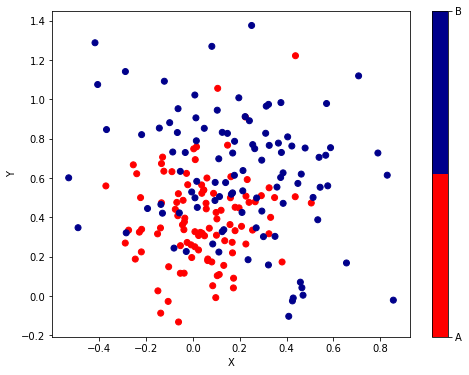

In [ ]:
# Generar dataset

# El centroide y covariancia de la clase A lo voy a dejar como estaba y voy a acercar el centroide de B y reescalar el atributo Y para que en el gráfico las distancias me queden comparables.
np.random.seed(1)
meanX_A = 0
meanX_B = 0.2
dsX_A = 0.2
dsX_B = 0.3
dfX = pd.DataFrame(np.random.normal(loc=[meanX_A,meanX_B], scale=[dsX_A,dsX_B], size=(100, 2)),columns=['X_A','X_B'])

# Ahora genero el dataset que represente el atributo Y para cada clase A y B con centoroides y DS distintas
np.random.seed(2)
meanY_A = 0.4
meanY_B = 0.6
dsY_A = 0.2
dsY_B = 0.3
dfY = pd.DataFrame(np.random.normal(loc=[meanY_A,meanY_B], scale=[dsY_A,dsY_B], size=(100, 2)),columns=['Y_A','Y_B'])

# Ahora a la clase A la voy a identificar con un 0 y a la clase B con un 1.
# Por último genero el dataset que me junte los atributos X e Y de cada clase y me muestre la etiqueta en la primer columna

dfA = pd.DataFrame({"etiqueta":np.zeros((100,), dtype=int), "X":dfX['X_A'], "Y":dfY['Y_A']})
dfB = pd.DataFrame({"etiqueta":np.ones((100,), dtype=int), "X":dfX['X_B'], "Y":dfY['Y_B']})

data = pd.concat([dfA,dfB], ignore_index=True)

# Diagrama de dispersión

etiquetas = ['A','B']
formatter = plt.FuncFormatter(lambda i, *args: etiquetas[int(i)])

plt.figure(figsize=(8, 6))
cmap_scatter = ListedColormap(['red', 'darkblue'])
plt.scatter(data["X"], data["Y"], c=data["etiqueta"], cmap=cmap_scatter)
plt.colorbar(ticks=[0, 1], format=formatter)
plt.xlabel("X")
plt.ylabel("Y")

plt.show()

Aquí vemos que las clases están bastante más "mezcladas". Trabajemos con este dataset.

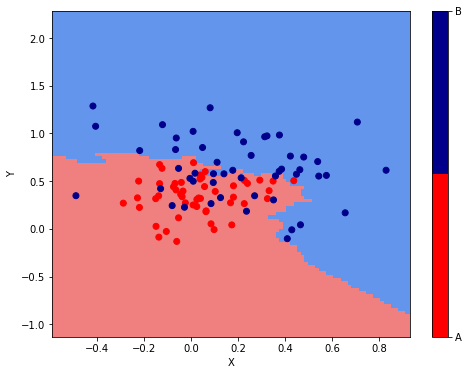

In [ ]:
# Genero los datasets de entrenamiento y de validación
N_train = 100

data_train_A = data.iloc[0:N_train//2,:]
data_train_B = data.iloc[100:100+N_train//2,:]
data_train = pd.concat([data_train_A,data_train_B], ignore_index=True)

X_train = data_train.iloc[:,1:3].values
y_train = data_train.iloc[:,0].values

data_valid_A = data.iloc[N_train//2:100,:]
data_valid_B = data.iloc[100+N_train//2:200,:]
data_valid = pd.concat([data_valid_A,data_valid_B], ignore_index=True)

X_valid = data_valid.iloc[:,1:3].values
y_valid = data_valid.iloc[:,0].values

# Entreno el clasificador
k_vecinos = 10  # Número de vecino a considerar

knn = neighbors.KNeighborsClassifier(n_neighbors=k_vecinos)
knn.fit(X_train,y_train)

# Calculo las predicciones con los datos que guardé para validar
y_pred = knn.predict(X_valid)

figura_dominios(X_train, y_train, knn)

Aquí vemos cómo la figura de los dominios de decisión del clasificador presenta información mucho más fácil de visualizar al tener las distancias en ambos ejes en la misma escala. Los datos de la clase A están mucho mejor agrupados por presentar una covariancia más chica y vemos cómo el clasificador establece el dominio de decisión alrededor de ellos. Evaluemos al igual que antes, los parámetros de evaluación en función de k.

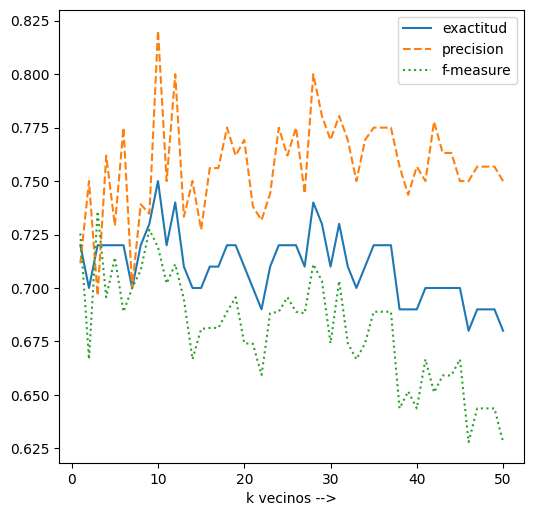

In [ ]:
k_vecinos_max = N_train//2

accuracy = np.ones([k_vecinos_max], dtype=np.float64)
precision = np.ones([k_vecinos_max], dtype=np.float64)
f_measure = np.ones([k_vecinos_max], dtype=np.float64)
x = np.ones([k_vecinos_max], dtype=np.float64)

for k_vecinos in range(1,k_vecinos_max+1):
  x[k_vecinos-1] = k_vecinos
  knn = neighbors.KNeighborsClassifier(n_neighbors=k_vecinos)
  knn.fit(X_train,y_train)
  y_pred = knn.predict(X_valid)
  accuracy[k_vecinos-1], precision[k_vecinos-1], f_measure[k_vecinos-1] = parametros(y_pred, y_valid)

plt.figure(figsize=(6, 6), dpi=100)
plt.plot(x, accuracy, linestyle='solid', label='exactitud')
plt.plot(x, precision, linestyle='dashed', label='precision')
plt.plot(x, f_measure, linestyle='dotted', label='f-measure')

plt.xlabel('k vecinos -->')

plt.legend()

plt.show()

Observamos que tanto la exactitud como la precisión alcanzan un máximo en k = 10, con valores apenas más bajo que para el dataset anterior (0.75 y 0.82). Además, la exactitud se comporta de manera estable en función del número de vecinos para comenzar a decrecer a partir de k = 40 aproximadamente. La precisión aumenta al principio para mantenerse estable a partir de k = 10. Esto nos indica que para valores pequeños de k el modelo es más inestable. Veamos los dominios de decisión para k = 3 y k = 50.

(None, None)

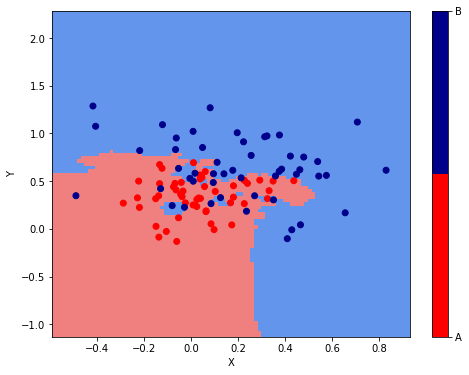

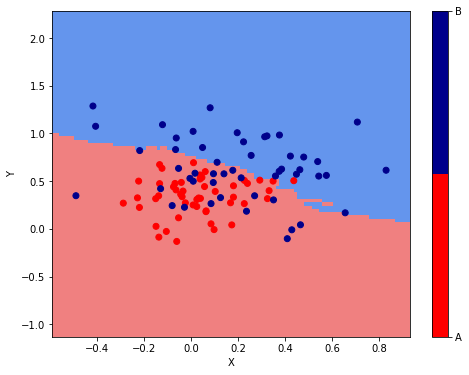

In [ ]:
# k =  3
knn3 = neighbors.KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train,y_train)
# k =  50
knn50 = neighbors.KNeighborsClassifier(n_neighbors=50)
knn50.fit(X_train,y_train)

figura_dominios(X_train, y_train, knn3) , figura_dominios(X_train, y_train, knn50)

Observamos al igual que antes que en el primer caso hay zonas donde el modelo es algo inestable y en el segundo generaliza por demás.

¿Qué pasa ahora si reducimos el valor de N? ¿Se comportará estable el modelo como antes o se romperá en algún momento?

╒════════════════╤════════════════════╤══════════════════╤══════════════════╤══════════════════╤══════════════════╕
│ KNN Classifier │ N = 100 and k = 10 │ N = 80 and k = 9 │ N = 60 and k = 8 │ N = 40 and k = 6 │ N = 20 and k = 4 │
├────────────────┼────────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│   Exactitud    │        0.78        │       0.68       │       0.71       │       0.66       │       0.58       │
├────────────────┼────────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│   Precisión    │        0.83        │       0.68       │       0.77       │       0.72       │       0.71       │
├────────────────┼────────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│   f-measure    │        0.76        │       0.67       │       0.68       │       0.61       │       0.39       │
╘════════════════╧════════════════════╧══════════════════╧══════════════

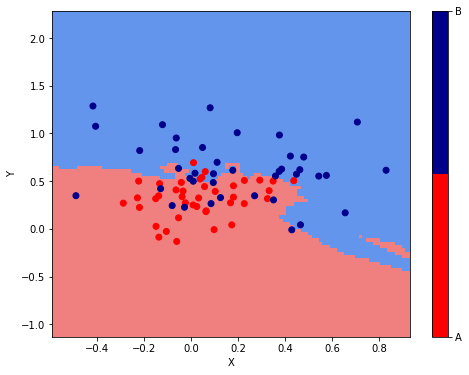

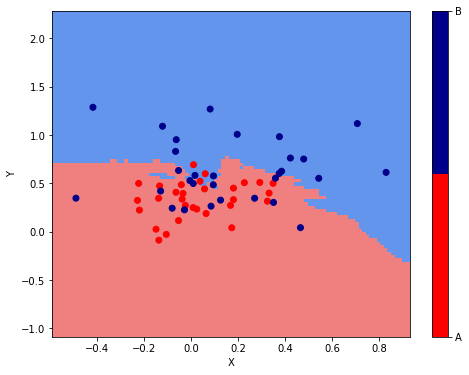

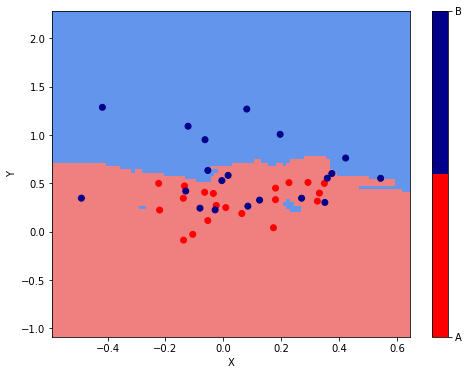

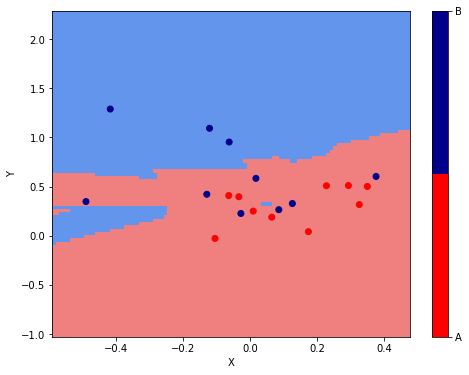

In [ ]:
# Genero los datasets de entrenamiento y de validación
N_train = 80

data_train_A = data.iloc[0:N_train//2,:]
data_train_B = data.iloc[100:100+N_train//2,:]
data_train = pd.concat([data_train_A,data_train_B], ignore_index=True)

X_train = data_train.iloc[:,1:3].values
y_train = data_train.iloc[:,0].values

data_valid_A = data.iloc[N_train//2:100,:]
data_valid_B = data.iloc[100+N_train//2:200,:]
data_valid = pd.concat([data_valid_A,data_valid_B], ignore_index=True)

X_valid = data_valid.iloc[:,1:3].values
y_valid = data_valid.iloc[:,0].values

# Entreno el clasificador
k_vecinos = 9  # Número de vecino a considerar

knn = neighbors.KNeighborsClassifier(n_neighbors=k_vecinos)
knn.fit(X_train,y_train)

# Calculo las predicciones con los datos que guardé para validar
y_pred = knn.predict(X_valid)

figura_dominios(X_train, y_train, knn)

accuracy_N80_k9, precision_N80_k9, f_measure_N80_k9 = parametros(y_pred, y_valid)

# Genero los datasets de entrenamiento y de validación
N_train = 60

data_train_A = data.iloc[0:N_train//2,:]
data_train_B = data.iloc[100:100+N_train//2,:]
data_train = pd.concat([data_train_A,data_train_B], ignore_index=True)

X_train = data_train.iloc[:,1:3].values
y_train = data_train.iloc[:,0].values

data_valid_A = data.iloc[N_train//2:100,:]
data_valid_B = data.iloc[100+N_train//2:200,:]
data_valid = pd.concat([data_valid_A,data_valid_B], ignore_index=True)

X_valid = data_valid.iloc[:,1:3].values
y_valid = data_valid.iloc[:,0].values

# Entreno el clasificador
k_vecinos = 8  # Número de vecino a considerar

knn = neighbors.KNeighborsClassifier(n_neighbors=k_vecinos)
knn.fit(X_train,y_train)

# Calculo las predicciones con los datos que guardé para validar
y_pred = knn.predict(X_valid)

figura_dominios(X_train, y_train, knn)

accuracy_N60_k8, precision_N60_k8, f_measure_N60_k8 = parametros(y_pred, y_valid)

# Genero los datasets de entrenamiento y de validación
N_train = 40

data_train_A = data.iloc[0:N_train//2,:]
data_train_B = data.iloc[100:100+N_train//2,:]
data_train = pd.concat([data_train_A,data_train_B], ignore_index=True)

X_train = data_train.iloc[:,1:3].values
y_train = data_train.iloc[:,0].values

data_valid_A = data.iloc[N_train//2:100,:]
data_valid_B = data.iloc[100+N_train//2:200,:]
data_valid = pd.concat([data_valid_A,data_valid_B], ignore_index=True)

X_valid = data_valid.iloc[:,1:3].values
y_valid = data_valid.iloc[:,0].values

# Entreno el clasificador
k_vecinos = 6  # Número de vecino a considerar

knn = neighbors.KNeighborsClassifier(n_neighbors=k_vecinos)
knn.fit(X_train,y_train)

# Calculo las predicciones con los datos que guardé para validar
y_pred = knn.predict(X_valid)

figura_dominios(X_train, y_train, knn)

accuracy_N40_k6, precision_N40_k6, f_measure_N40_k6 = parametros(y_pred, y_valid)

# Genero los datasets de entrenamiento y de validación
N_train = 20

data_train_A = data.iloc[0:N_train//2,:]
data_train_B = data.iloc[100:100+N_train//2,:]
data_train = pd.concat([data_train_A,data_train_B], ignore_index=True)

X_train = data_train.iloc[:,1:3].values
y_train = data_train.iloc[:,0].values

data_valid_A = data.iloc[N_train//2:100,:]
data_valid_B = data.iloc[100+N_train//2:200,:]
data_valid = pd.concat([data_valid_A,data_valid_B], ignore_index=True)

X_valid = data_valid.iloc[:,1:3].values
y_valid = data_valid.iloc[:,0].values

# Entreno el clasificador
k_vecinos = 4  # Número de vecino a considerar

knn = neighbors.KNeighborsClassifier(n_neighbors=k_vecinos)
knn.fit(X_train,y_train)

# Calculo las predicciones con los datos que guardé para validar
y_pred = knn.predict(X_valid)

figura_dominios(X_train, y_train, knn)

accuracy_N20_k4, precision_N20_k4, f_measure_N20_k4 = parametros(y_pred, y_valid)

tabla = [['KNN Classifier', 'N = 100 and k = 10', 'N = 80 and k = 9', 'N = 60 and k = 8', 'N = 40 and k = 6', 'N = 20 and k = 4'],
         ['Exactitud', round(accuracy_N100_k10,2), round(accuracy_N80_k9,2), round(accuracy_N60_k8,2), round(accuracy_N40_k6,2), round(accuracy_N20_k4,2)],
         ['Precisión', round(precision_N100_k10,2), round(precision_N80_k9,2), round(precision_N60_k8,2), round(precision_N40_k6,2), round(precision_N20_k4,2)],
         ['f-measure', round(f_measure_N100_k10,2), round(f_measure_N80_k9,2), round(f_measure_N60_k8,2), round(f_measure_N40_k6,2), round(f_measure_N20_k4,2)]]
        
print(tabulate(tabla,
               tablefmt='fancy_grid',
               stralign='center'))

Bueno, vemos que ya con solamente bajar N de 100 a 80 la precisión y exactitud del modelo disminuyen significativamente y para N = 20 el modelo se termina de romper, arrojando valores muy pequeños. Por lo tanto un valor de N = 100 es adecuado para este dataset con centroides cercanos.

## **Más dimensiones**

Si agregamos más dimensiones al dataset lo que va a ocurrir es que aumenta el tiempo de cómputo del clasificador ya que si bien debe evaluar N distancias, cada distancia depende de la diferencia entre los valores de cada atributo. Por ejemplo, para atributos X, Y y Z tendría que evaluar N distancias del tipo:

$\sqrt{(x_i-x_j)^2+(y_i-y_j)^2+(z_i-z_j)^2}$

De todas formas, en nuestro caso, como estamos trabajando con datasets chicos no debería afectar tanto. Sí sería más complejo visualizar los dominios de decisión, deberíamos elegir dos atributos y ver en función de ellos y así.

# **Ejercicio 3.2**

Hacer alguna experiencia con el dataset anterior utilizando validación cruzada y (o) grid search.

## **K-Folds cross-validator**

Fold 1:  exactitud =  0.72 precision =  0.69
Fold 2:  exactitud =  0.72 precision =  0.82
Fold 3:  exactitud =  0.75 precision =  0.91
Fold 4:  exactitud =  0.75 precision =  1.0
Fold 5:  exactitud =  0.78 precision =  0.8


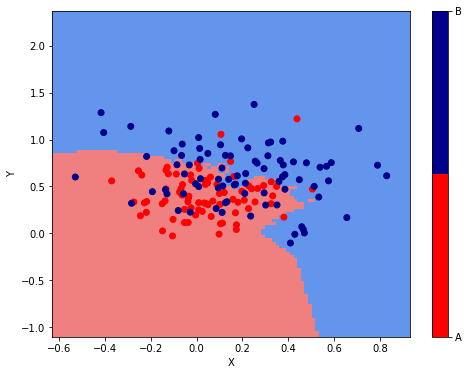

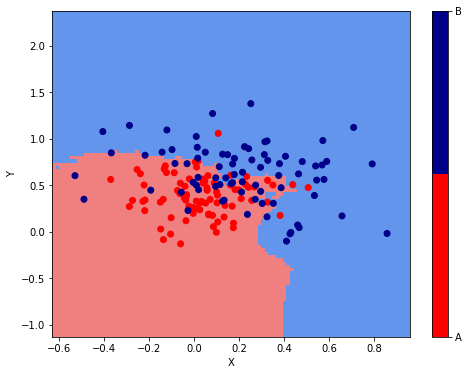

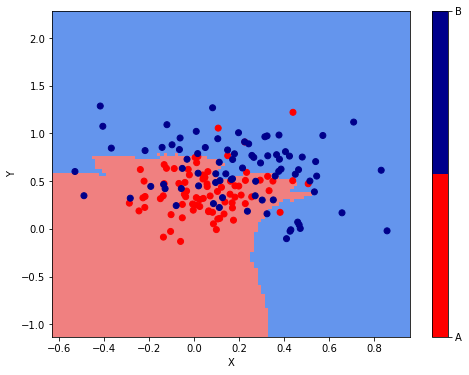

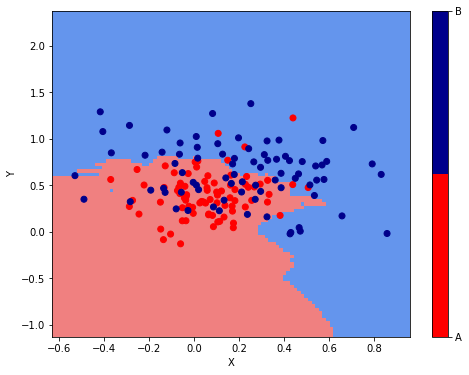

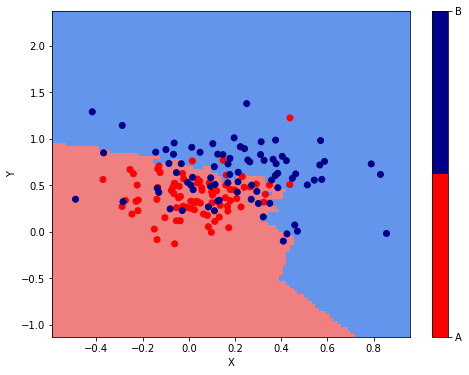

In [ ]:
# Separo las variables data de la variable target
X = data.iloc[:,1:3].values
y = data.iloc[:,0].values

from sklearn.model_selection import KFold

# Mi dataset cuenta con 200 datos (100 de A y 100 de B). Elijo 5 splits, por lo que estoy eligiendo 160 datos para entrenar y 40 para testear en cada iteración.
# Los mezclo con shuffle porque vienen ordenados por clase.
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Entrenemos el clasificador para cada split y grafiquemos los dominios de decisión y calculemos los parámetros de evaluación
k_vecinos = 10  # Número de vecino a considerar
knn = neighbors.KNeighborsClassifier(n_neighbors=k_vecinos)

i = 1
for train_index, test_index in kf.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  knn.fit(X_train,y_train)
  y_pred = knn.predict(X_test)

  figura_dominios(X_train, y_train, knn)

  accuracy, precision, f_measure = parametros(y_pred, y_test)

  print('Fold {}: '.format(i), 'exactitud = ', round(accuracy, 2), 'precision = ', round(precision, 2))

  i+=1

Observamos que para cada fold el modelo se comporta distinto arrojando diferentes valores de precision y exactitud y cambiando los dominios de decisión sobre todo en la zona de conflicto entre clases. Por lo tanto el modelo presenta inestabilidad y el muestreo parece tener influencia. Puede ser que la cantidad de datos utilizados para entrenar sea muy grande para el valor de k considerado. Probemos con 2 splits donde tendremos 100 datos de entrenamiento donde ya vimos que el modelo se comporta de manera estable.

Fold 1:  exactitud =  0.67 precision =  0.88
Fold 2:  exactitud =  0.82 precision =  0.8


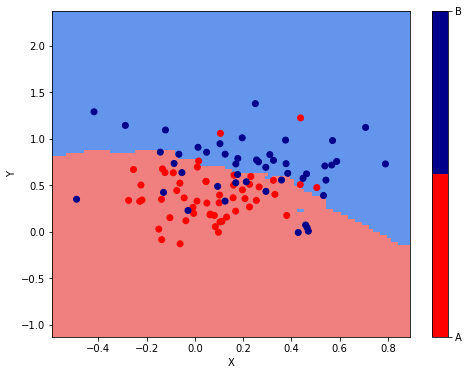

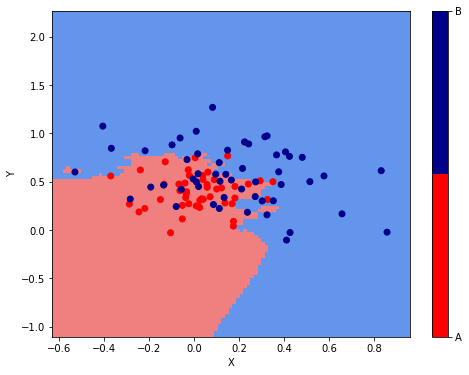

In [ ]:
kf = KFold(n_splits=2, shuffle=True, random_state=2)

# Entrenemos el clasificador para cada split y grafiquemos los dominios de decisión y calculemos los parámetros de evaluación
k_vecinos = 10  # Número de vecino a considerar
knn = neighbors.KNeighborsClassifier(n_neighbors=k_vecinos)

i = 1
for train_index, test_index in kf.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  knn.fit(X_train,y_train)
  y_pred = knn.predict(X_test)

  figura_dominios(X_train, y_train, knn)

  accuracy, precision, f_measure = parametros(y_pred, y_test)

  print('Fold {}: '.format(i), 'exactitud = ', round(accuracy, 2), 'precision = ', round(precision, 2))

  i+=1

Aquí vemos que el modelo arroja valores muy distintos de exactitud y precisión para cada split. Además, los dominios de decisión para cada split son muy diferentes. Lo que puede estar ocurriendo es que contemos con muy pocos datos dentro del dataset como para que el muestreo no tenga influencia. 200 datos quizás sea una estadística muy baja para realizar una generalización y garantizar que el modelo clasifique correctamente datos nuevos que le pasemos.

## **Grid Search Hyper-parameter optimizer**

In [ ]:
# Genero los datasets de entrenamiento y de validación
N_train = 100

data_train_A = data.iloc[0:N_train//2,:]
data_train_B = data.iloc[100:100+N_train//2,:]
data_train = pd.concat([data_train_A,data_train_B], ignore_index=True)

X_train = data_train.iloc[:,1:3].values
y_train = data_train.iloc[:,0].values

data_valid_A = data.iloc[N_train//2:100,:]
data_valid_B = data.iloc[100+N_train//2:200,:]
data_valid = pd.concat([data_valid_A,data_valid_B], ignore_index=True)

X_valid = data_valid.iloc[:,1:3].values
y_valid = data_valid.iloc[:,0].values

from sklearn.model_selection import GridSearchCV

# Vamos a recorrer el espacio de k vecinos entre 1 y 50
k_vecinos = []
for k in range(1,50):
  k_vecinos.append(k)

parameters = {'n_neighbors': k_vecinos}

gs = GridSearchCV(neighbors.KNeighborsClassifier(), parameters, verbose = 1, cv = 2)

gs_results = gs.fit(X_train, y_train)

Fitting 2 folds for each of 49 candidates, totalling 98 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:    0.3s finished


In [ ]:
print(gs_results.best_estimator_)
print(gs_results.best_score_)
print(gs_results.best_params_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=27, p=2,
                     weights='uniform')
0.8
{'n_neighbors': 27}


In [ ]:
# Vamos a recorrer ahora además con funciones peso y métricas distintas.
parameters = {'n_neighbors': k_vecinos, 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}

gs = GridSearchCV(neighbors.KNeighborsClassifier(), parameters, verbose = 1, cv = 5) #Cambié la cross validation a 5

gs_results = gs.fit(X_train, y_train)

print(gs_results.best_estimator_)
print(gs_results.best_score_)
print(gs_results.best_params_)

Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')
0.8
{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'uniform'}


[Parallel(n_jobs=1)]: Done 980 out of 980 | elapsed:    1.9s finished


Aquí vemos que Grid Search me dice que el mejor modelo es para 4 vecinos con métrica manhattan y sin ponderación respecto de los vecinos. Veamos qué obtengo con esos parámetros.

exactitud =  0.71 precision =  0.76


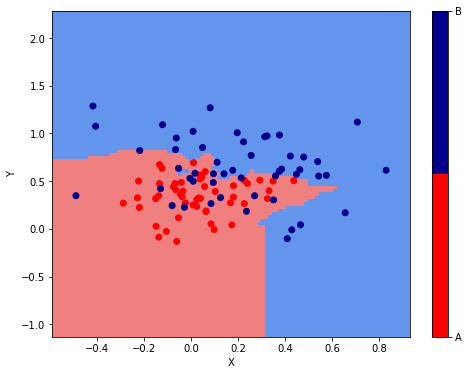

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=4, metric='manhattan', weights='uniform')

knn.fit(X_train,y_train)
y_pred = knn.predict(X_valid)

figura_dominios(X_train, y_train, knn)

accuracy, precision, f_measure = parametros(y_pred, y_valid)

print('exactitud = ', round(accuracy, 2), 'precision = ', round(precision, 2))